In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tfds.load('mnist', split=['train', 'test'], as_supervised=True, batch_size=-1)

# convert ot JAX arrays
train_images = jnp.array(train_images)
train_labels = jnp.array(train_labels)
test_images = jnp.array(test_images)
test_labels = jnp.array(test_labels)

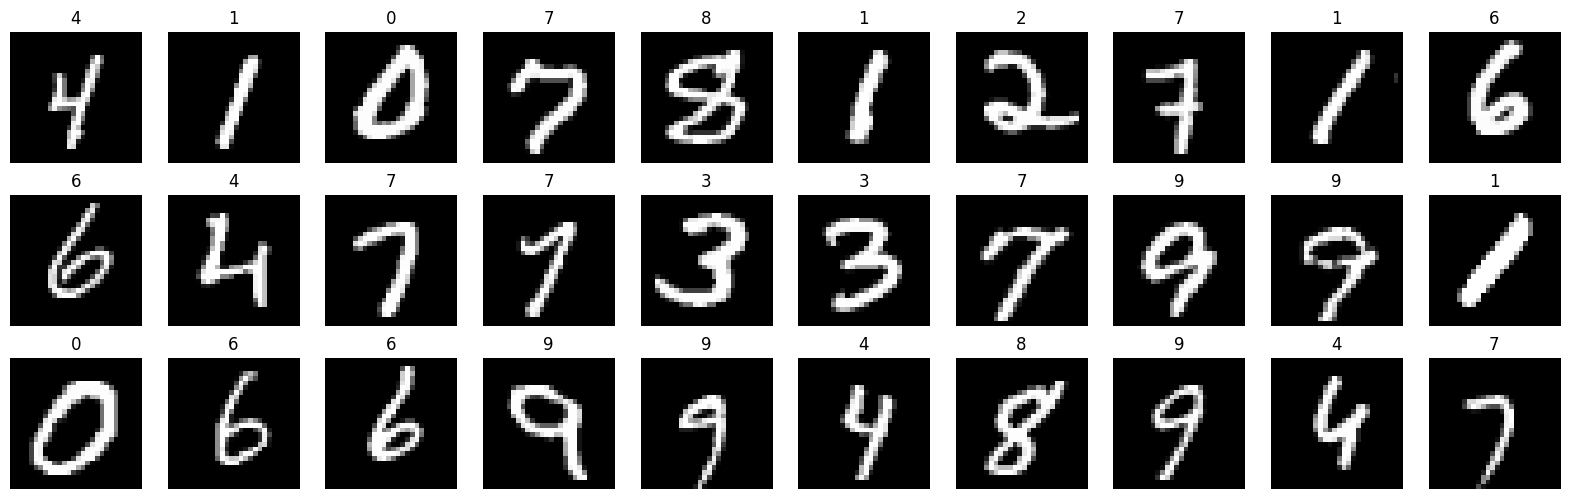

In [15]:
def show_digits(images, labels=None, n=30, rows=3, cols=10, figsize=(20, 6)):
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)
    axs = axs.reshape((-1,))
    for i in range(n): 
        axs[i].imshow(images[i], cmap="gray")
        if labels is not None:
            axs[i].set_title(labels[i])
        axs[i].axis("off")

show_digits(train_images[:30], train_labels[:30])

In [16]:
# Explore the dataset
print("Train images: ", train_images.shape[0])
print("Test images: ", test_images.shape[0])
print("Image shape: ", train_images.shape[1:])

print("\nNumber of classes: ", len(jnp.unique(train_labels)))
print("class 0: ", jnp.sum(train_labels == 0))
print("class 1: ", jnp.sum(train_labels == 1))
print("class 2: ", jnp.sum(train_labels == 2))
print("class 3: ", jnp.sum(train_labels == 3))
print("class 4: ", jnp.sum(train_labels == 4))
print("class 5: ", jnp.sum(train_labels == 5))
print("class 6: ", jnp.sum(train_labels == 6))
print("class 7: ", jnp.sum(train_labels == 7))
print("class 8: ", jnp.sum(train_labels == 8))
print("class 9: ", jnp.sum(train_labels == 9))

Train images:  60000
Test images:  10000
Image shape:  (28, 28, 1)

Number of classes:  10
class 0:  5923
class 1:  6742
class 2:  5958
class 3:  6131
class 4:  5842
class 5:  5421
class 6:  5918
class 7:  6265
class 8:  5851
class 9:  5949


In [17]:
# Use only the images of the digit 1, 4 and 8
digit_1 = train_images[train_labels == 1][:200]
digit_4 = train_images[train_labels == 4][:200]
digit_8 = train_images[train_labels == 8][:200]
train_images = jnp.concatenate([digit_1, digit_4, digit_8], axis=0)

# Normalize the images
train_images = train_images / 255.0

# Scale the images to the range [-1, 1]
train_images = 2 * train_images - 1

# Shuffle the dataset
train_images = jax.random.permutation(jax.random.PRNGKey(0), train_images)

print("Train images: ", train_images.shape)

Train images:  (600, 28, 28, 1)


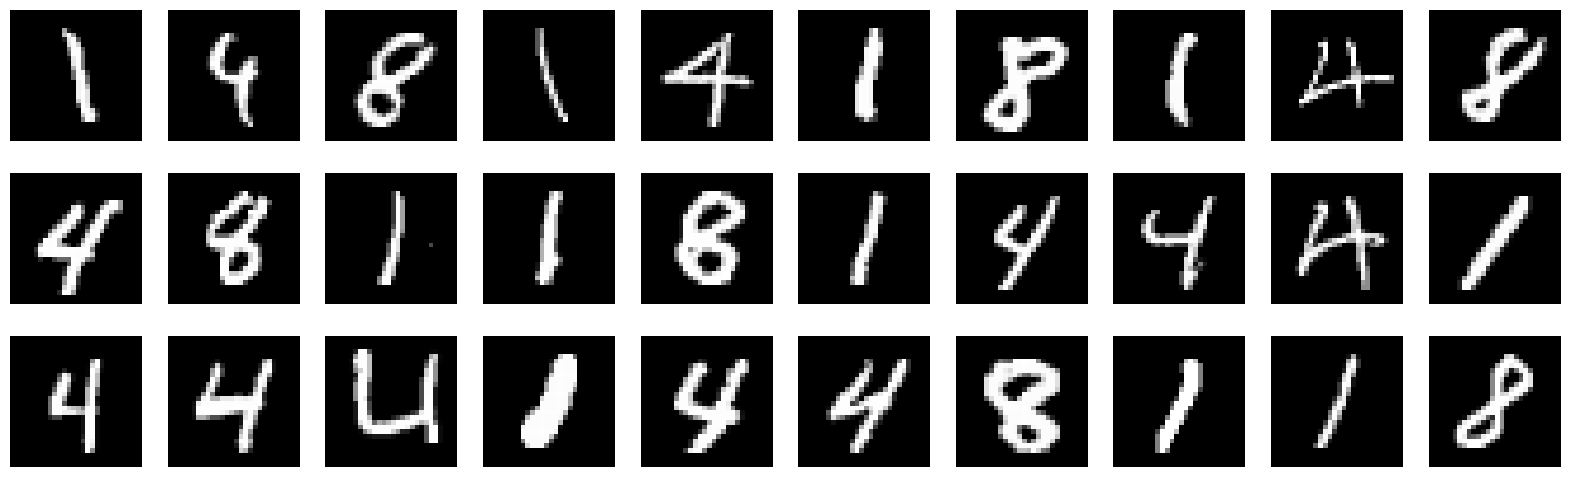

In [18]:
show_digits(train_images[:30])

### Generator and Discriminator Networks

The **Generator** creates fake images from random noise, while the **Discriminator** distinguishes between real and fake images.

- **Generator:**
  - Takes a latent vector as input.
  - Uses two hidden layers with ReLU activation.
  - Outputs an image with pixel values scaled between `[-1, 1]` using Tanh.

- **Discriminator:**
  - Takes an image as input.
  - Uses two hidden layers with Leaky ReLU activation.
  - Outputs a single value (logit) indicating the probability of the image being real.

In [19]:
class Generator(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(128)(z)
        x = nn.relu(x)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(28 * 28)(x)
        x = nn.tanh(x)
        return x.reshape(-1, 28, 28)
    
class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, 28 * 28)
        x = nn.Dense(256)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(128)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(1)(x)
        x = nn.sigmoid(x)
        return x

qualche commento

In [20]:
latent_dim = 64
key = jax.random.PRNGKey(0)

gen = Generator(latent_dim=latent_dim)
disc = Discriminator()

# Initialize parameters
gen_params = gen.init(key, jax.random.normal(key, (1, latent_dim)))
disc_params = disc.init(key, train_images[0])

# Define optimizers
gen_optimizer = optax.adam(1e-4)
disc_optimizer = optax.adam(1e-4)

gen_opt_state = gen_optimizer.init(gen_params)
disc_opt_state = disc_optimizer.init(disc_params)

In [21]:
# Print generator parameters
print("Generator parameters:")
for param_group, param_dict in gen_params.items():
    for param_name, layer in param_dict.items():
        print(f"  Shape of {param_name}:\n   Bias: {layer['bias'].shape}\n   Kernel: {layer['kernel'].shape}")

print("\nDiscriminator parameters:")
# Print discriminator parameters
for param_group, param_dict in disc_params.items():
    for param_name, layer in param_dict.items():
        print(f"  Shape of {param_name}:\n   Bias: {layer['bias'].shape}\n   Kernel: {layer['kernel'].shape}")

Generator parameters:
  Shape of Dense_0:
   Bias: (128,)
   Kernel: (64, 128)
  Shape of Dense_1:
   Bias: (256,)
   Kernel: (128, 256)
  Shape of Dense_2:
   Bias: (784,)
   Kernel: (256, 784)

Discriminator parameters:
  Shape of Dense_0:
   Bias: (256,)
   Kernel: (784, 256)
  Shape of Dense_1:
   Bias: (128,)
   Kernel: (256, 128)
  Shape of Dense_2:
   Bias: (1,)
   Kernel: (128, 1)


### GAN Loss Functions

#### Discriminator Loss $ L_D $

The discriminator loss $ L_D $ is a binary cross-entropy loss, defined as:

$$
L_D = - \mathbb{E}_{x \sim p_{\text{data}}} \left[ \log D(x) \right] - \mathbb{E}_{z \sim p_z} \left[ \log \left( 1 - D(G(z)) \right) \right]
$$

Where:
- $ D(x) $ should output 1 for real images.
- $ D(G(z)) $ should output 0 for fake images generated by $ G(z) $.

This loss encourages the discriminator to correctly classify real and fake images.

#### Generator Loss $ L_G $

The generator loss $ L_G $ aims to fool the discriminator into classifying fake images as real. It is typically defined as:

$$
L_G = - \mathbb{E}_{z \sim p_z} \left[ \log D(G(z)) \right]
$$

Where:
- $ D(G(z)) $ represents the discriminator’s probability of classifying a generated image $ G(z) $ as real.

This loss encourages the generator to improve its ability to produce images that the discriminator cannot distinguish from real ones.

In [22]:
def generator_loss(gen_params, disc_params, z):
    # Generate fake images
    fake_images = gen.apply(gen_params, z)

    # Get the discriminator's predictions on fake images
    fake_preds = disc.apply(disc_params, fake_images)
    
    # Calculate the loss
    loss = -jnp.mean(jnp.log(jnp.clip(fake_preds, 1e-7, 1.0)))
    
    return loss

def discriminator_loss(disc_params, real_images, fake_images):
    # Get the discriminator's predictions on real and fake images
    real_preds = disc.apply(disc_params, real_images)
    fake_preds = disc.apply(disc_params, fake_images)

    # Calculate the loss
    real_loss = -jnp.mean(jnp.log(jnp.clip(real_preds, 1e-7, 1.0)))
    fake_loss = -jnp.mean(jnp.log(jnp.clip(1.0 - fake_preds, 1e-7, 1.0)))

    return real_loss + fake_loss

Commento

In [23]:
@jax.jit
def train_step(gen_params, disc_params, gen_opt_state, disc_opt_state, real_images, z):
    # Generate fake images
    fake_images = gen.apply(gen_params, z)

    # Calculate the discriminator loss (Should only depend on the discriminator parameters)
    disc_loss, disc_grads = jax.value_and_grad(discriminator_loss)(disc_params, real_images, fake_images)

    # Update discriminator
    disc_updates, disc_opt_state = disc_optimizer.update(disc_grads, disc_opt_state)
    disc_params = optax.apply_updates(disc_params, disc_updates)

    # Calculate the generator loss (Depends on both the generator and discriminator parameters)
    gen_loss, gen_grads = jax.value_and_grad(generator_loss)(gen_params, disc_params, z)

    # Update generator
    gen_updates, gen_opt_state = gen_optimizer.update(gen_grads, gen_opt_state)
    gen_params = optax.apply_updates(gen_params, gen_updates)

    return gen_params, disc_params, gen_opt_state, disc_opt_state, gen_loss, disc_loss

In [ ]:
@jax.jit
def disc_train_step(disc_params, disc_opt_state, real_images, fake_images):
    # Calculate the discriminator loss (Should only depend on the discriminator parameters)
    disc_loss, disc_grads = jax.value_and_grad(discriminator_loss)(disc_params, real_images, fake_images)

    # Update discriminator
    disc_updates, disc_opt_state = disc_optimizer.update(disc_grads, disc_opt_state)
    disc_params = optax.apply_updates(disc_params, disc_updates)

    return disc_params, disc_opt_state, disc_loss

@jax.jit
def gen_train_step(gen_params, disc_params, gen_opt_state, z):
    # Calculate the generator loss (Depends on both the generator and discriminator parameters)
    gen_loss, gen_grads = jax.value_and_grad(generator_loss)(gen_params, disc_params, z)

    # Update generator
    gen_updates, gen_opt_state = gen_optimizer.update(gen_grads, gen_opt_state)
    gen_params = optax.apply_updates(gen_params, gen_updates)

    return gen_params, gen_opt_state, gen_loss

In [24]:
num_epochs = 10000
batch_size = 128
num_batches = train_images.shape[0] // batch_size

gen_images = []
for epoch in range(num_epochs):
    for i in range(num_batches):
        # Sample a new batch of real images
        real_images = train_images[i * batch_size: (i + 1) * batch_size]

        # Generate random latent vectors
        key, subkey = jax.random.split(key)
        z = jax.random.normal(key, (batch_size, latent_dim))

        gen_params, disc_params, gen_opt_state, disc_opt_state, gen_loss, disc_loss = train_step(gen_params, disc_params, gen_opt_state, disc_opt_state, real_images, z)
        
        # Slower, i don't know why ???
        # # Train the discriminator
        # fake_images = gen.apply(gen_params, z)
        # disc_params, disc_opt_state, disc_loss = disc_train_step(disc_params, disc_opt_state, real_images, fake_images)

        # # Train the generator
        # gen_params, gen_opt_state, gen_loss = gen_train_step(gen_params, disc_params, gen_opt_state, z)
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Generator loss: {gen_loss}, Discriminator loss: {disc_loss}")

    if epoch % 1000 == 0:
        fake_images = gen.apply(gen_params, jax.random.normal(key, (10, latent_dim)))
        gen_images.append(fake_images)

fake_images = gen.apply(gen_params, jax.random.normal(key, (30, latent_dim)))
gen_images.append(fake_images)

Epoch 0, Generator loss: 0.5969797372817993, Discriminator loss: 1.1260913610458374
Epoch 100, Generator loss: 2.761056900024414, Discriminator loss: 0.16598910093307495
Epoch 200, Generator loss: 3.872307777404785, Discriminator loss: 0.14364169538021088
Epoch 300, Generator loss: 4.781257629394531, Discriminator loss: 0.10529762506484985
Epoch 400, Generator loss: 4.717928886413574, Discriminator loss: 0.08914563059806824
Epoch 500, Generator loss: 4.895777702331543, Discriminator loss: 0.10416162014007568
Epoch 600, Generator loss: 5.114531517028809, Discriminator loss: 0.13912543654441833
Epoch 700, Generator loss: 4.245086669921875, Discriminator loss: 0.20494550466537476
Epoch 800, Generator loss: 4.297611713409424, Discriminator loss: 0.3491029143333435
Epoch 900, Generator loss: 4.149083137512207, Discriminator loss: 0.15898829698562622
Epoch 1000, Generator loss: 3.277695655822754, Discriminator loss: 0.31128162145614624
Epoch 1100, Generator loss: 3.5922884941101074, Discrimi

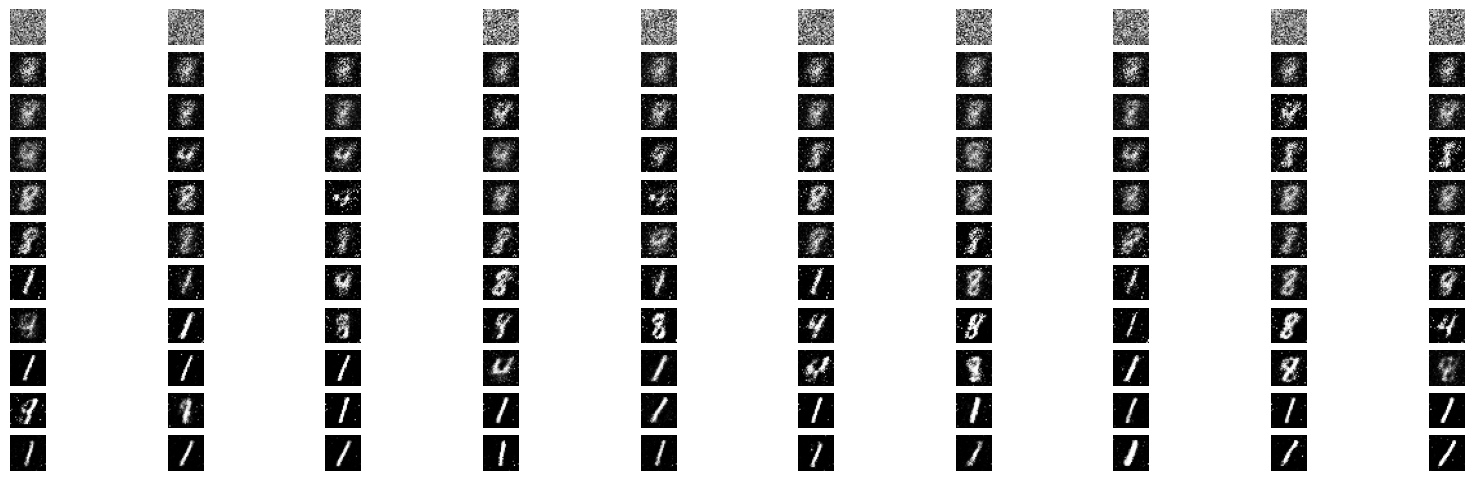

In [25]:
show_digits(jnp.concatenate(gen_images), n=10*len(gen_images), rows=len(gen_images))

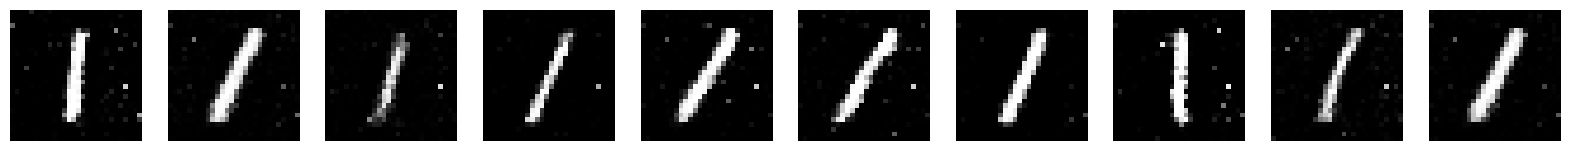

In [29]:
key, subkey = jax.random.split(key)
show_digits(gen.apply(gen_params, jax.random.normal(key, (10, latent_dim))), n=10, rows=1)

In [ ]:
import pickle

# Save the generator parameters
with open("gen_params.pkl", "wb") as f:
    pickle.dump(gen_params, f)